# Supervised learning of SNN with local rule 'STDP+all-LTD'

SNN is trained on the MNIST dataset using the local rule 'STDP+all-LTD' (supervised learning).

Changes in version 2:   
- Homeostasis (adaptive threshold) is added for excitatory neurons. Every time neurons spikes, its threshold increases by certain amount.

In [1]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import csv
import time
import random

2023-09-22 10:23:13.733046: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 10:23:13.759928: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 10:23:13.760415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 10:23:14.266239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Selecting data from the MNIST dataset

In [2]:
# select only 3 arbitrary classes out of 10

classes = random.sample(range(10), 3)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_size = 28*28 # input image size
X_train = X_train.reshape(60000, img_size)
X_test = X_test.reshape(10000, img_size)

# simplified classification
X_train = X_train[(y_train == classes[0]) | (y_train == classes[1]) | (y_train == classes[2])]
y_train = y_train[(y_train == classes[0]) | (y_train == classes[1]) | (y_train == classes[2])]
X_test = X_test[(y_test == classes[0]) | (y_test == classes[1]) | (y_test == classes[2])]
y_test = y_test[(y_test == classes[0]) | (y_test == classes[1]) | (y_test == classes[2])]

# pixel intensity to Hz (255 becoms ~63Hz)
X_train = X_train / 4
X_test = X_test / 4

print(f'classes: {classes}')
X_train.shape, X_test.shape

classes: [3, 8, 6]


((17900, 784), (2942, 784))

## Initial data + Model

In [3]:
n_input = 28*28 # input layer

# Setting 10 neurons per class
n_e = 30 # e - excitatory
n_i = n_e # i - inhibitory

# v - membrane potential
v_rest_e = -60.*mV 
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

taupre = 20*ms
taupost = taupre
gmax = .05 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

wi = 3 # strength of inhibitory synapse

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr1 : 1
    lr2 : 1
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr1*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr2*Apre, 0, gmax)'''

#---------------------------------------------------------------------------------------------------------

class Model():

    def __init__(self):
        app = {}

        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')

        # excitatory group + eq: dvt/dt = (v_thresh_e-vt)/(150*ms) : volt
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dvt/dt = (v_thresh_e-vt)/(150*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            v2 : volt
            '''

        # adaptive threshold
        # the idea is borrowed from https://brian2.readthedocs.io/en/stable/examples/adaptive_threshold.html
   
        reset_e = '''
        v = v_reset_e
        vt += 3*mV
        '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v2', 
                                refractory=5*ms, reset=reset_e, 
                                method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV        
        app['EG'].vt = v_thresh_e
        app['EG'].v2 = v_thresh_e
        
        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')         
            
        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', 
                                refractory=2*ms, reset='v=v_reset_i', 
                                method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')

        # poisson generators one-to-all excitatory neurons with plastic connections
        for cl in range(len(classes)):
            # we should have a possibility to independently change learning rate for every class subgroup
            app[f'S1_{cl}'] = Synapses(app['PG'], app['EG'][cl*10:(cl+1)*10], stdp, on_pre=pre, on_post=post, method='euler', 
                                       name=f'S1_{cl}')
            app[f'S1_{cl}'].connect()
            app[f'S1_{cl}'].w = 'rand()*gmax' # random weights initialisation
            app[f'S1_{cl}'].lr1 = 1 # enable stdp
            app[f'S1_{cl}'].lr2 = 1 # enable stdp

        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = wi # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = wi/n_e # weights are selected in such a way as to maintain a balance between excitation and ibhibition

        self.net = Network(app.values())
        self.net.run(0*second)

    def __getitem__(self, key):
        return self.net[key]

    def train(self, X, targets, epoch=1):
        # X is the input image
        # y is the label for image X
        
        for ep in range(epoch):
            for idx in range(len(X)):
                yt = int(targets[idx]) # target class
                self.net['EG'].v2 = 'vt'

                # set learning rate for each subgroup of excitatory neurons
                for cl in range(len(classes)):
                    if cl == classes.index(yt):
                        self.net[f'S1_{cl}'].lr1 = 1 # regular STDP
                        self.net[f'S1_{cl}'].lr2 = 1
                    else:
                        self.net[f'S1_{cl}'].lr1 = 1  # all-LTD
                        self.net[f'S1_{cl}'].lr2 = -1

                # active mode
                self.net['PG'].rates = X[idx].ravel()*Hz
                self.net.run(0.35*second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)


    def evaluate(self, X, targets):
        
        self.net['EG'].v2 = v_thresh_e           

        for cl in range(len(classes)):
            self.net[f'S1_{cl}'].lr1 = 0  # turn off learning (freezing synaptic weights)
            self.net[f'S1_{cl}'].lr2 = 0  # turn off learning (freezing synaptic weights)

        cc = 0 # number of correct classifications
        
        for idx in range(len(X)):
            yt = int(targets[idx]) # target class

            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], record=False, name='RM')
            self.net.add(mon)

            # active mode
            self.net['PG'].rates = X[idx].ravel()*Hz
            self.net.run(0.35*second)

            counts = [] # spike counts for every group
            
            # calculate spike count for every group of excitatory neurons
            for cl in range(len(classes)):
                counts.append(sum(mon.count[cl*10:(cl+1)*10]))
            if counts.index(max(counts)) == classes.index(yt): # check the correctness of prediction
                cc += 1

            # passive mode
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)

            self.net.remove(self.net['RM']) # delete monitor to free up memory


        return cc/len(X) # return accuracy

## Model activation

In [4]:
model = Model()

## Train + test
At each stage, a test is performed on 1000 images after training on 100 images.

In [5]:
# train-n-test proceeding

train_items=100 
test_items=1000

print(f'Classes: {classes}')
list_accuracy = []
total_time = 0

for i in range(50):
    
    start0 = time.time()
    model.train(X_train[:train_items], y_train[:train_items], epoch=1)
    end0 = time.time()
    total_time += end0 - start0
    
    start = time.time()
    accuracy = model.evaluate(X_test[:test_items], y_test[:test_items])
    list_accuracy.append(accuracy) 
    end = time.time()
    total_time += end - start
    
    print(f'{i}. train time: {int((end0 - start0)//60)}:{int((end0 - start0)%60)}' \
          f'- test time:  {int((end - start)//60)}:{int((end - start)%60)}'\
          f'- total time:  {int((total_time)//60)} min {int((total_time)%60)} sec')

    print(f'   - classification accuracy = {accuracy*100 :.1f}%')

Classes: [3, 8, 6]
0. train time: 0:38- test time:  6:50- total time:  7 min 29 sec
   - classification accuracy = 82.4%
1. train time: 0:39- test time:  6:47- total time:  14 min 56 sec
   - classification accuracy = 80.6%
2. train time: 0:40- test time:  6:45- total time:  22 min 21 sec
   - classification accuracy = 79.6%
3. train time: 0:39- test time:  6:48- total time:  29 min 49 sec
   - classification accuracy = 82.0%
4. train time: 0:40- test time:  6:52- total time:  37 min 21 sec
   - classification accuracy = 81.4%
5. train time: 0:39- test time:  6:51- total time:  44 min 52 sec
   - classification accuracy = 83.2%
6. train time: 0:39- test time:  7:4- total time:  52 min 36 sec
   - classification accuracy = 84.0%
7. train time: 0:40- test time:  6:54- total time:  60 min 11 sec
   - classification accuracy = 85.0%
8. train time: 0:40- test time:  6:56- total time:  67 min 48 sec
   - classification accuracy = 84.2%
9. train time: 0:40- test time:  6:49- total time:  75 m

## Results chart

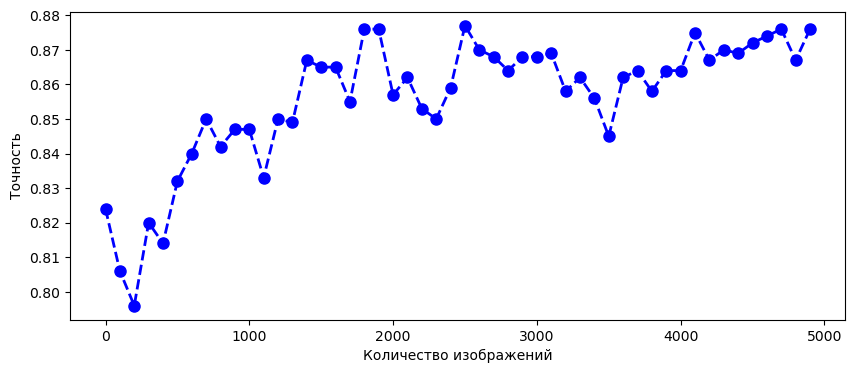

In [6]:
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(np.arange(len(list_accuracy))*100, list_accuracy, color='blue', marker='o', linestyle='dashed',
     linewidth=2, markersize=8)
plt.ylabel('Точность') # accuracy
plt.xlabel('Количество изображений') # train images
plt.show();

In [7]:
with open('list_dynamic_accuracy.csv', 'w') as file:
        csv.writer(file, delimiter=';').writerow(list_accuracy)

In [8]:
path = f'./'
list_dynamic_accuracy = pd.read_csv(f'{path}list_dynamic_accuracy.csv', delimiter=';')
list_dynamic_accuracy

,0.824,0.806,0.796,0.82,0.814,0.832,0.84,0.85,0.842,0.847,...,0.864.3,0.875,0.867.1,0.87.1,0.869.1,0.872,0.874,0.876.2,0.867.2,0.876.3
